# MANUAL DATA COLLECTION

In [2]:
#%matplotlib inline
%matplotlib widget

In [3]:
import time, math, numpy as np

# ------------------ flip controller (same as before) ------------------
def flip_policy(t, U_MIN=-1.0, U_MAX=1.0):
    """
    Simple open-loop sequence to try to flip the truck.
    Tune the timings / signs for your model.
    """
    if t < 0.5:
        return U_MAX        # punch in one direction
    elif t < 1.0:
        return U_MIN        # rebound
    elif t < 2.5:
        return U_MAX        # second kick
    else:
        return 0.0          # let it fly / settle

# ------------------ helpers: quat -> rotation + up vector ------------------
def quat_to_R_and_pitch(qw, qx, qy, qz):
    """
    Returns:
      R      : 3x3 rotation matrix (body -> world)
      pitch  : standard Euler pitch (for debugging, may have singularities)
    """
    # Rotation matrix for unit quaternion (w, x, y, z)
    R00 = 1 - 2*(qy*qy + qz*qz)
    R01 = 2*(qx*qy - qw*qz)
    R02 = 2*(qx*qz + qw*qy)

    R10 = 2*(qx*qy + qw*qz)
    R11 = 1 - 2*(qx*qx + qz*qz)
    R12 = 2*(qy*qz - qw*qx)

    R20 = 2*(qx*qz - qw*qy)
    R21 = 2*(qy*qz + qw*qx)
    R22 = 1 - 2*(qx*qx + qy*qy)

    # "classic" Euler pitch just for debugging
    pitch = -math.asin(max(-1.0, min(1.0, R20)))

    R = np.array([[R00, R01, R02],
                  [R10, R11, R12],
                  [R20, R21, R22]], dtype=float)
    return R, pitch

def unwrap_angle(prev_angle, prev_unwrapped, angle):
    """
    Incremental unwrap of an angle in [-pi, pi] so it becomes continuous.
    """
    if prev_angle is None:
        return angle, angle  # first call
    d = angle - prev_angle
    # handle wrap-around at ±pi
    if d > math.pi:
        angle_unwrapped = prev_unwrapped + (d - 2*math.pi)
    elif d < -math.pi:
        angle_unwrapped = prev_unwrapped + (d + 2*math.pi)
    else:
        angle_unwrapped = prev_unwrapped + d
    return angle, angle_unwrapped

In [25]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mujoco as mj
import mujoco.viewer as viewer

# ------------------ config ------------------
CTRL_DT   = 0.4
DURATION  = 60.0
U_MIN, U_MAX = -1.0, 1.0
RTF      = 1.0
REFRESH_HZ = 5
#MODEL_XML = "monstertruck.xml"
MODEL_XML = "monstertruck_old.xml"

# ------------------ model + sensors ------------------
m = mj.MjModel.from_xml_path(MODEL_XML)
data = mj.MjData(m)
mj.mj_resetData(m, data); mj.mj_forward(m, data)
data.ctrl[:] = 0.0

sim_dt        = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
if gyro_id < 0:
    raise RuntimeError("imu_gyro sensor not found in model XML")
gyro_adr = m.sensor_adr[gyro_id]

acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
if acc_id < 0:
    raise RuntimeError("imu_acc sensor not found in model XML")
acc_adr = m.sensor_adr[acc_id]

# ------------------ plotting ------------------
plt.ioff()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

(line_pitch,)   = ax1.plot([], [], lw=1.4)
(line_flip,)    = ax2.plot([], [], lw=1.4)
(line_u,)       = ax3.plot([], [], lw=1.4)
(line_rate,)    = ax4.plot([], [], lw=1.4)
(line_acc,)     = ax5.plot([], [], lw=1.0)

ax1.set_ylabel("Euler pitch [rad]")
ax1.set_ylim(-np.pi, np.pi); ax1.grid(True, linewidth=0.3)

ax2.set_ylabel("flip angle rel [rad]")
ax2.set_ylim(-3.5, 3.5); ax2.grid(True, linewidth=0.3)

ax3.set_ylabel("u")
ax3.set_ylim(U_MIN-0.1, U_MAX+0.1); ax3.grid(True, linewidth=0.3)

ax4.set_ylabel("pitch rate [rad/s]")
ax4.set_ylim(-10, 10); ax4.grid(True, linewidth=0.3)

ax5.set_ylabel("acc imu")
ax5.set_ylim(-50, 50); ax5.set_xlabel("time [s]"); ax5.grid(True, linewidth=0.3)

# small inset axis for the up-vector (v_z, v_x)
ax_up = fig.add_axes([0.45, 0.48, 0.18, 0.18])  # [left, bottom, width, height]
theta_circle = np.linspace(-np.pi, np.pi, 200)
ax_up.plot(np.cos(theta_circle), np.sin(theta_circle), 'k--', linewidth=0.8)
(line_upvec,) = ax_up.plot([], [], 'b-', lw=1.4)
ax_up.set_aspect('equal', adjustable='box')
ax_up.set_xlim(-1.1, 1.1)
ax_up.set_ylim(-1.1, 1.1)
ax_up.set_xlabel("v_z (up/down)")
ax_up.set_ylabel("v_x (fwd/back)")
ax_up.set_title("Up-vector on circle", fontsize=9)

fig.tight_layout()
display(fig)

# ------------------ logs ------------------
t_log         = []
pitch_log     = []
flip_rel_log  = []
u_log         = []
rate_log      = []
acc_log       = []
vz_log        = []
vx_log        = []

last_refresh_wall = time.perf_counter()

t0_sim   = data.time
t0_wall  = time.perf_counter()
next_cmd = t0_sim
u = 0.0

# for angle unwrapping & reference
prev_theta = None
prev_theta_unwrapped = 0.0
theta0 = None  # reference angle at t=0 (so flip_rel starts near 0)

#with viewer.launch_passive(m, data) as v:
while data.time - t0_sim < DURATION:
    # --- control update ---
    if data.time >= next_cmd:
        t_rel = data.time - t0_sim
        #u = float(np.clip(flip_policy(t_rel, U_MIN, U_MAX), U_MIN, U_MAX))
        u = float(np.random.uniform(U_MIN, U_MAX))
        data.ctrl[:] = u
        next_cmd += CTRL_DT

    # --- physics ---
    mj.mj_step(m, data)

    # --- state & orientation ---
    qw, qx, qy, qz = data.qpos[qadr:qadr+4]
    R, euler_pitch = quat_to_R_and_pitch(qw, qx, qy, qz)

    # body "up" vector in world coordinates = 3rd column of R
    up_x, up_y, up_z = R[0, 2], R[1, 2], R[2, 2]

    # angle of up vector in (z,x) plane: atan2(v_x, v_z) in [-pi, pi]
    theta = math.atan2(up_x, up_z)

    # unwrap over time to avoid jump at ±pi
    prev_theta, theta_unwrapped = unwrap_angle(prev_theta, prev_theta_unwrapped, theta)
    prev_theta_unwrapped = theta_unwrapped

    # define reference at the first step so car starts at ~0
    if theta0 is None:
        theta0 = theta_unwrapped
    flip_rel = theta_unwrapped - theta0  # this is your "progress" angle

    # IMU signals
    gyro = data.sensordata[gyro_adr:gyro_adr+3]
    pitch_rate_imu = float(gyro[1])

    acc = data.sensordata[acc_adr:acc_adr+3]
    acc_imu = float(acc[0])

    t_rel = data.time - t0_sim

    # --- log ---
    t_log.append(t_rel)
    pitch_log.append(euler_pitch)
    flip_rel_log.append(flip_rel)
    u_log.append(u)
    rate_log.append(pitch_rate_imu)
    acc_log.append(acc_imu)
    vz_log.append(up_z)
    vx_log.append(up_x)

    # --- plotting ---
    now = time.perf_counter()
    if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
        line_pitch.set_data(t_log, pitch_log)
        line_flip.set_data(t_log, flip_rel_log)
        line_u.set_data(t_log, u_log)
        line_rate.set_data(t_log, rate_log)
        line_acc.set_data(t_log, acc_log)

        line_upvec.set_data(vz_log, vx_log)

        ax1.set_xlim(0.0, max(2.0, t_rel))
        clear_output(wait=True)
        display(fig)
        last_refresh_wall = now

    # --- real-time pacing ---
    sim_elapsed  = data.time - t0_sim
    target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
    sleep_needed = target_wall - time.perf_counter()
    if sleep_needed > 0:
        time.sleep(min(sleep_needed, 0.01))

        #v.sync()

# final draw
line_pitch.set_data(t_log, pitch_log)
line_flip.set_data(t_log, flip_rel_log)
line_u.set_data(t_log, u_log)
line_rate.set_data(t_log, rate_log)
line_acc.set_data(t_log, acc_log)
line_upvec.set_data(vz_log, vx_log)

ax1.set_xlim(0.0, max(2.0, t_log[-1] if t_log else 2.0))
clear_output(wait=True)
display(fig)

print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s")

RuntimeError: imu_gyro sensor not found in model XML

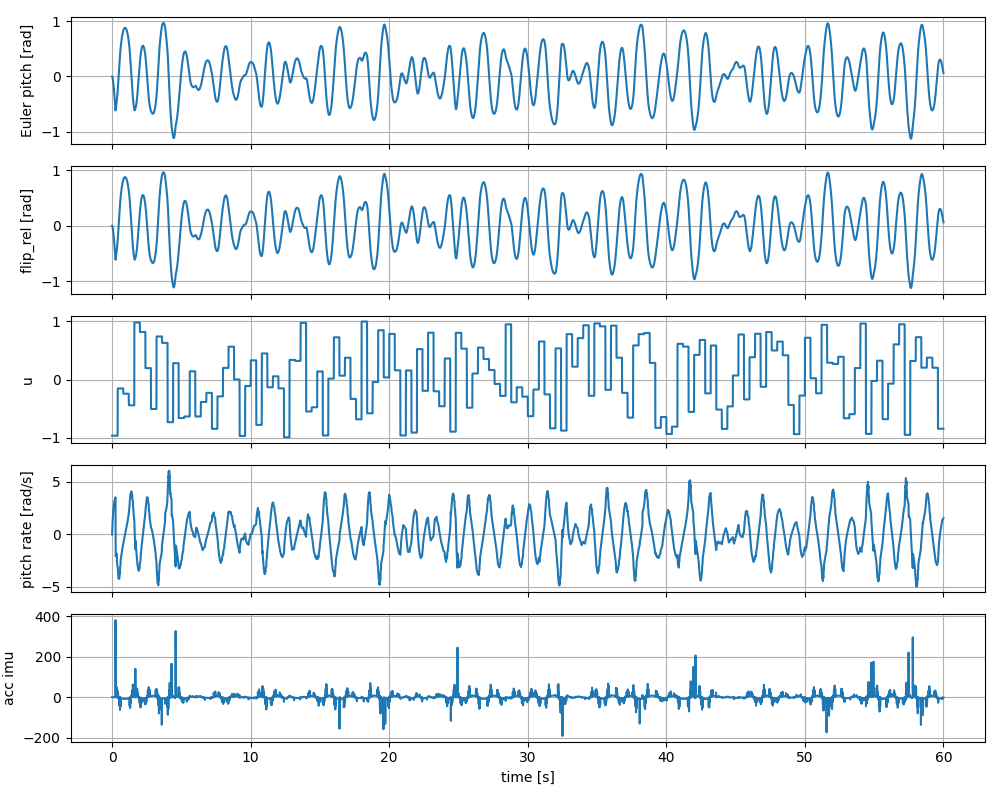

In [5]:
import matplotlib.pyplot as plt
import numpy as np

t      = np.array(t_log)
pitch  = np.array(pitch_log)
flip_r = np.array(flip_rel_log)
u      = np.array(u_log)
rate   = np.array(rate_log)
acc    = np.array(acc_log)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

ax1.plot(t, pitch);  ax1.set_ylabel("Euler pitch [rad]"); ax1.grid(True)
ax2.plot(t, flip_r); ax2.set_ylabel("flip_rel [rad]");    ax2.grid(True)
ax3.plot(t, u);      ax3.set_ylabel("u");                 ax3.grid(True)
ax4.plot(t, rate);   ax4.set_ylabel("pitch rate [rad/s]");ax4.grid(True)
ax5.plot(t, acc);    ax5.set_ylabel("acc imu");           ax5.set_xlabel("time [s]"); ax5.grid(True)

plt.tight_layout()
plt.show()


In [6]:
# # MuJoCo viewer (real-time paced) + live 3-row plot (pitch [rad], action, pitch rate [rad/s])

# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output
# import mujoco as mj
# import mujoco.viewer as viewer

# # -------- config --------
# CTRL_DT   = 0.1          # control update period (sim seconds)
# DURATION  = 60.0          # total run time (sim seconds)
# U_MIN, U_MAX = -1.0, 1.0  # throttle bounds
# RTF      = 1.0            # realtime factor: 1.0=real-time, 0.5=half-speed, 2.0=2x
# REFRESH_HZ = 6            # plot refresh rate (wall-clock)

# # XML path
# MODEL_XML = "monstertruck.xml"

# # -------- model --------
# m = mj.MjModel.from_xml_path(MODEL_XML)
# #d = mj.MjData(m)
# data = mj.MjData(m)
# mj.mj_resetData(m, data); mj.mj_forward(m, data)
# data.ctrl[:] = 0.0

# sim_dt        = float(m.opt.timestep)
# steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
# free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
# qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# # --- IMU gyro sensor (for pitch rate) ---
# gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
# if gyro_id < 0:
#     raise RuntimeError("imu_gyro sensor not found in model XML")
# gyro_adr = m.sensor_adr[gyro_id]  # start index in data.sensordata


# # --- IMU acc sensor (for pitch rate) ---
# acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
# if acc_id < 0:
#     raise RuntimeError("acc_id sensor not found in model XML")
# acc_adr = m.sensor_adr[acc_id]  # start index in data.sensordata


# # -------- live plot setup --------
# plt.ioff()  # we'll redraw manually via clear_output
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# (line_pitch,)       = ax1.plot([], [], lw=1.8)
# (line_u,)           = ax2.plot([], [], lw=1.4)
# (line_rate,)        = ax3.plot([], [], lw=1.4)
# (line_rate_imu,)    = ax3.plot([], [], lw=1.4)
# (line_drate_imu,)    = ax4.plot([], [], lw=1.4)

# ax1.set_ylabel("pitch [rad]")
# ax1.set_ylim(-1, 1)
# ax1.grid(True, linewidth=0.3)

# ax2.set_ylabel("u")
# ax2.set_ylim(-1.1, 1.1)
# ax2.grid(True, linewidth=0.3)

# ax3.set_ylabel("pitch rate (phi_dot)")
# ax3.set_xlabel("time [s]")
# ax3.set_ylim(-5.0, 5.0)   # adjust if you see clipping
# ax3.grid(True, linewidth=0.3)

# ax4.set_ylabel("d pitch rate imu")
# ax4.set_xlabel("time [s]")
# ax4.set_ylim(-50.0, 50.0)   # adjust if you see clipping
# ax4.grid(True, linewidth=0.3)

# fig.tight_layout()
# display(fig)

# rate_imu_1= 0.0


# # -------- run viewer --------
# t_log, pitch_log, u_log, rate_log, rate_imu_log, drate_imu_log = [], [], [], [], [], []
# last_refresh_wall = time.perf_counter()

# #with viewer.launch_passive(m, data) as v:
# t0_sim   = data.time
# t0_wall  = time.perf_counter()
# next_cmd = t0_sim
# u = 0.0

# prev_pitch = None

# while data.time - t0_sim < DURATION:
#     # choose a new random throttle every CTRL_DT (sim time)
#     if data.time >= next_cmd:
#         u = float(np.random.uniform(U_MIN, U_MAX))
#         data.ctrl[:] = u
#         next_cmd += CTRL_DT

#     # one physics tick
#     mj.mj_step(m, data)

#     # read pitch and compute pitch rate (wrapped finite diff over sim_dt)
#     qw, qx, qy, qz = data.qpos[qadr:qadr+4]
#     _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

#     if prev_pitch is None:
#         rate = 0.0
#     else:
#         rate = (pitch - prev_pitch) #angdiff(pitch, prev_pitch) / sim_dt
#     prev_pitch = pitch

#     ## CALCULATE SPEED FROM IMU
#     # imu_gyro is angular velocity in IMU local frame: [wx, wy, wz] (rad/s)
#     gyro = data.sensordata[gyro_adr : gyro_adr + 3]
#     rate_imu = float(gyro[1])

#     # imu_gyro is angular velocity in IMU local frame: [acc_x, acc_y, acc_z] (rad/s)
#     acc = data.sensordata[acc_adr : acc_adr + 3]
#     acc_imu = float(acc[0])

#     ## CALCULATE ACCELERATION
#     dd_rate_imu = (rate_imu - rate_imu_1)/sim_dt
#     rate_imu_1 = rate_imu

#     t_rel = data.time - t0_sim
    
#     t_log.append(t_rel)
#     pitch_log.append(pitch)
#     u_log.append(u)
#     rate_log.append(rate)
#     rate_imu_log.append(rate_imu)
#     drate_imu_log.append(acc_imu)

#     # live-plot at REFRESH_HZ (wall time)
#     now = time.perf_counter()
#     if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
#         line_pitch.set_data(t_log, pitch_log)
#         line_u.set_data(t_log, u_log)
#         #line_rate.set_data(t_log, rate_log)
#         line_rate_imu.set_data(t_log, rate_imu_log)
#         line_drate_imu.set_data(t_log, drate_imu_log)
#         ax1.set_xlim(0.0, max(5.0, t_rel))
#         clear_output(wait=True)
#         display(fig)
#         last_refresh_wall = now

#     # real-time pacing
#     sim_elapsed  = data.time - t0_sim
#     target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
#     sleep_needed = target_wall - time.perf_counter()
#     if sleep_needed > 0:
#         time.sleep(min(sleep_needed, 0.01))

#     #v.sync()

# # final draw
# line_pitch.set_data(t_log, pitch_log)
# line_u.set_data(t_log, u_log)
# #line_rate.set_data(t_log, rate_log)
# line_rate_imu.set_data(t_log, rate_imu_log)
# line_drate_imu.set_data(t_log, drate_imu_log)
# ax1.set_xlim(0.0, max(5.0, t_log[-1] if t_log else 5.0))
# clear_output(wait=True)
# display(fig)

# print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s")


# GAUSSIAN PROCESS DYNAMICS

In [7]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -----------------------------------
# ============================================================

device = torch.device("cuda")

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RQKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: data + normalization -----------
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=300, device=device):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.device = device

        self.trained = False
        self.X_train = None
        self.Y_train = None

        self.likelihood = None
        self.model = None

    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.tensor(Y, dtype=torch.float32, device=self.device)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32, device=self.device)
        Y_new = torch.tensor(Y_new, dtype=torch.float32, device=self.device).flatten()

        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean = self.X_train.mean(0)
        self.X_std  = self.X_train.std(0)
        self.Y_mean = self.Y_train.mean()
        self.Y_std  = self.Y_train.std()

        # avoid division by zero
        self.X_std = torch.where(self.X_std == 0.0, torch.ones_like(self.X_std), self.X_std)
        if self.Y_std == 0.0:
            self.Y_std = torch.tensor(1.0, device=self.device)

        self.Xn = (self.X_train - self.X_mean) / self.X_std
        self.Yn = (self.Y_train - self.Y_mean) / self.Y_std

    def dataset(self):
        X_train = self.X_train.detach().cpu().numpy()
        Y_train = self.Y_train.detach().cpu().numpy()
        return X_train, Y_train

    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)

        self.model = ExactGPModel(
            self.Xn, self.Yn, self.likelihood,
            kernel=self.kernel,
            ard_dims=self.X_train.shape[-1]
        ).to(self.device)

        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    # ----- Torch-friendly predict (for MPPI on GPU) -----
    def predict_torch(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))
            mean = pred.mean * self.Y_std + self.Y_mean
            var  = pred.variance * (self.Y_std ** 2)
        return mean, var


In [8]:
from scipy.signal import butter, filtfilt
import numpy as np

def lowpass_offline(acc, dt, cutoff_hz=5.0, order=2):
    acc = np.asarray(acc, dtype=float)
    fs = 1.0 / dt
    wn = cutoff_hz / (fs / 2.0)
    wn = min(max(wn, 1e-6), 0.999999)
    b, a = butter(order, wn, btype='low')
    acc_filt = filtfilt(b, a, acc)  # zero-phase forward+backward
    return acc_filt

dt = np.mean(np.diff(t_log))
acc_filt_log = lowpass_offline(acc_log, dt, cutoff_hz=5.0, order=2)


In [9]:
# import numpy as np

# # --------------------------------------------------------------
# # Build dataset from logs (DYNAMICS AS DELTAS)
# # --------------------------------------------------------------

# pitch_arr = np.asarray(flip_rel_log, dtype=np.float32)
# rate_arr  = np.asarray(rate_log,  dtype=np.float32)
# drate_arr = np.asarray(acc_filt_log,  dtype=np.float32)
# u_arr     = np.asarray(u_log,     dtype=np.float32)

# N = min(len(pitch_arr), len(rate_arr), len(u_arr))
# pitch_arr = pitch_arr[:N]
# rate_arr  = rate_arr[:N]
# u_arr     = u_arr[:N]

# # # Inputs at time t: [pitch_t, rate_t, u_t]
# # X_full = np.stack([pitch_arr[:-1], rate_arr[:-1], u_arr[:-1]], axis=1)

# # # Targets: deltas (s_{t+1} - s_t)
# # Y_full = np.stack([
# #     rate_arr[:-1],   # Δpitch
# #     drate_arr[:-1] # Δrate
# # ], axis=1)

# X_full = np.stack([pitch_arr[:-1], rate_arr[:-1], u_arr[:-1]], axis=1)
# Y_full = np.stack([
#     (pitch_arr[1:] - pitch_arr[:-1]) / dt,   # d(flip)/dt
#     (rate_arr[1:] - rate_arr[:-1]) / dt    # d(rate)/dt
# ], axis=1)

# print("Full X shape:", X_full.shape)
# print("Full Y shape:", Y_full.shape)

# # --------------------------------------------------------------
# # Subsample: take every 10th sample
# # --------------------------------------------------------------
# step = 100  # change to 20, 50, etc. if needed
# X = X_full[::step]
# Y = Y_full[::step]

# print("Subsampled X shape:", X.shape)
# print("Subsampled Y shape:", Y.shape)

# # --------------------------------------------------------------
# # Train GP dynamics models (reuse your existing GPManager)
# # --------------------------------------------------------------
# n_output = Y.shape[1]  # 2: Δpitch, Δrate

# ## KERNELS RBF, Matern, RQ
# gps = [GPManager(kernel='Matern', iters=300) for _ in range(n_output)]

# for d in range(n_output):
#     gps[d].fit(X, Y[:, d])
#     print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")








import numpy as np

# --------------------------------------------------------------
# 0) Assume these logs already exist from your data collection:
#     flip_rel_log  : list of flip-relative angles over time
#     rate_log      : list of angular rates (pitch_rate_imu)
#     u_log         : list of actions
#     dt            : time step used for deltas (e.g. CTRL_DT)
# --------------------------------------------------------------

flip_arr = np.asarray(flip_rel_log, dtype=np.float32)
rate_arr = np.asarray(rate_log,      dtype=np.float32)
u_arr    = np.asarray(u_log,         dtype=np.float32)

# Make sure all same length and chop to N
N = min(len(flip_arr), len(rate_arr), len(u_arr))
flip_arr = flip_arr[:N]
rate_arr = rate_arr[:N]
u_arr    = u_arr[:N]

# --------------------------------------------------------------
# 1) Build full state–action / delta-state dataset
#     X_full(t) = [flip_t, rate_t, u_t]
#     Y_full(t) = [d(flip)/dt, d(rate)/dt]
# --------------------------------------------------------------
# One-step-ahead pairs: (t -> t+1)
X_full = np.stack([
    flip_arr[:-1],
    rate_arr[:-1],
    u_arr[:-1]
], axis=1)

Y_full = np.stack([
    (flip_arr[1:] - flip_arr[:-1]) / dt,   # d(flip)/dt
    (rate_arr[1:] - rate_arr[:-1]) / dt    # d(rate)/dt
], axis=1)

print("Full X shape:", X_full.shape)  # (N-1, 3)
print("Full Y shape:", Y_full.shape)  # (N-1, 2)

# Convenience aliases
flip_all = X_full[:, 0]
rate_all = X_full[:, 1]

# --------------------------------------------------------------
# 2) Helper selection functions
# --------------------------------------------------------------
def stratified_by_value_indices(values, n_bins=20, max_per_bin=50, seed=0):
    """
    Uniform-ish coverage over 'values' (e.g., flip_rel).
    Returns a list of indices.
    """
    rng = np.random.default_rng(seed)
    v_min, v_max = float(values.min()), float(values.max())
    if v_min == v_max:
        # All values the same -> just random pick
        all_idx = np.arange(len(values))
        rng.shuffle(all_idx)
        return all_idx[:max_per_bin]

    bins = np.linspace(v_min, v_max, n_bins + 1)
    chosen = []
    for i in range(n_bins):
        mask = (values >= bins[i]) & (values < bins[i+1])
        idx_bin = np.nonzero(mask)[0]
        if len(idx_bin) == 0:
            continue
        rng.shuffle(idx_bin)
        chosen.extend(idx_bin[:max_per_bin])
    return np.array(chosen, dtype=int)


def stratified_by_abs_value_indices(values, n_bins=10, max_per_bin=50, seed=1):
    """
    Uniform-ish coverage over abs(values) (e.g., |rate|).
    """
    rng = np.random.default_rng(seed)
    abs_v = np.abs(values)
    v_min, v_max = float(abs_v.min()), float(abs_v.max())
    if v_min == v_max:
        all_idx = np.arange(len(values))
        rng.shuffle(all_idx)
        return all_idx[:max_per_bin]

    bins = np.linspace(v_min, v_max, n_bins + 1)
    chosen = []
    for i in range(n_bins):
        mask = (abs_v >= bins[i]) & (abs_v < bins[i+1])
        idx_bin = np.nonzero(mask)[0]
        if len(idx_bin) == 0:
            continue
        rng.shuffle(idx_bin)
        chosen.extend(idx_bin[:max_per_bin])
    return np.array(chosen, dtype=int)


def farthest_point_subset(X, M=500, seed=2):
    """
    Simple greedy farthest-point sampling in feature space.
    Picks M diverse points from X (N,D).
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    if M >= N:
        return np.arange(N, dtype=int)

    # Start from a random point
    first = rng.integers(0, N)
    chosen = [first]

    # Squared distances to the chosen set (init as +inf)
    d2 = np.full(N, np.inf, dtype=np.float64)

    for _ in range(1, M):
        last_idx = chosen[-1]
        diff = X - X[last_idx]           # (N, D)
        new_d2 = np.sum(diff**2, axis=1) # (N,)
        d2 = np.minimum(d2, new_d2)

        # pick the farthest point from current chosen set
        next_idx = int(np.argmax(d2))
        chosen.append(next_idx)

    return np.array(chosen, dtype=int)



def choose_selection_params(N_full, N_target=2500):
    frac_far    = 0.4
    frac_angle  = 0.25
    frac_rate   = 0.25
    frac_stride = 0.10

    N_far    = int(frac_far    * N_target)
    N_angle  = int(frac_angle  * N_target)
    N_rate   = int(frac_rate   * N_target)
    N_stride = max(1, int(frac_stride * N_target))

    # Farthest-point
    M = N_far

    # Angle bins/limit
    n_bins_angle      = 24
    max_per_bin_angle = max(1, N_angle // n_bins_angle)

    # Rate bins/limit
    n_bins_rate       = 12
    max_per_bin_rate  = max(1, N_rate // n_bins_rate)

    # Temporal stride
    stride = max(1, int(N_full / N_stride))

    return {
        "M": M,
        "n_bins_angle": n_bins_angle,
        "max_per_bin_angle": max_per_bin_angle,
        "n_bins_rate": n_bins_rate,
        "max_per_bin_rate": max_per_bin_rate,
        "stride": stride,
    }



# --------------------------------------------------------------
# 3) Build combined index set from the 3 strategies
# --------------------------------------------------------------
N_Target = 1000
params = choose_selection_params(X_full.shape[0], N_target=N_Target)

idx_angle = stratified_by_value_indices(
    flip_all,
    n_bins=params["n_bins_angle"],
    max_per_bin=params["max_per_bin_angle"],
    seed=0
)

idx_rate = stratified_by_abs_value_indices(
    rate_all,
    n_bins=params["n_bins_rate"],
    max_per_bin=params["max_per_bin_rate"],
    seed=1
)

idx_far = farthest_point_subset(
    X_full,
    M=params["M"],
    seed=2
)

idx_stride = np.arange(0, X_full.shape[0], params["stride"], dtype=int)

idx_all = np.unique(np.concatenate([idx_angle, idx_rate, idx_far, idx_stride]))
print("Selected:", len(idx_all), " (target ≈", N_Target, ")")


# --------------------------------------------------------------
# 4) Final training set (shuffle)
# --------------------------------------------------------------
rng = np.random.default_rng(123)
rng.shuffle(idx_all)

X = X_full[idx_all]
Y = Y_full[idx_all]

print("Final X shape:", X.shape)
print("Final Y shape:", Y.shape)

# --------------------------------------------------------------
# 5) Train GP dynamics models using your GPManager
# --------------------------------------------------------------
n_output = Y.shape[1]  # 2: [d(flip)/dt, d(rate)/dt]

# ## KERNELS RBF, Matern, RQ

gps = [GPManager(kernel='RQ', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for d_state[{d}] with {len(X)} samples.")


Full X shape: (60000, 3)
Full Y shape: (60000, 2)
Selected: 968  (target ≈ 1000 )
Final X shape: (968, 3)
Final Y shape: (968, 2)
Trained GP for d_state[0] with 968 samples.
Trained GP for d_state[1] with 968 samples.


# Visualize Collected Data

Plotting for action a=-1.0
Values near action a=-1.0 n=286


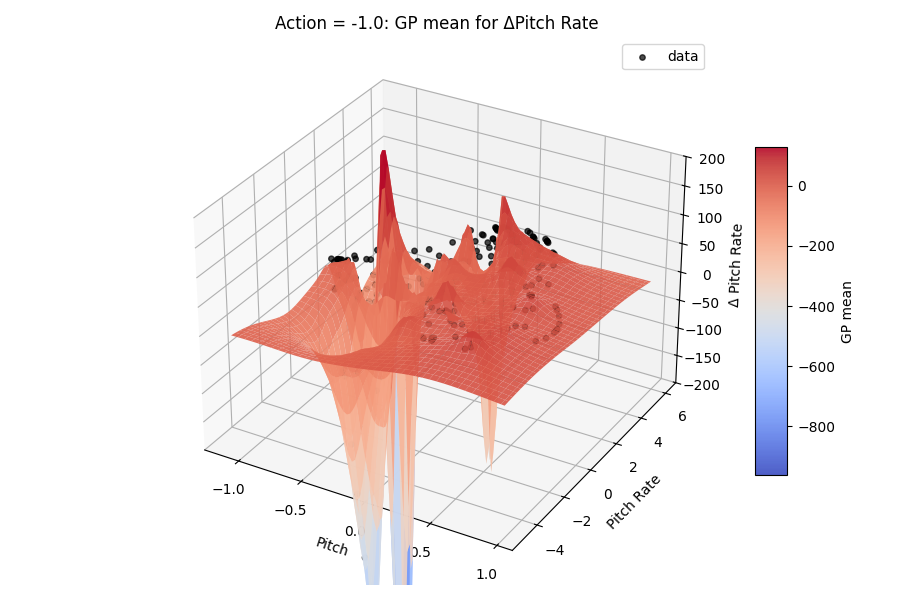

Plotting for action a=0.27
Values near action a=0.27 n=435


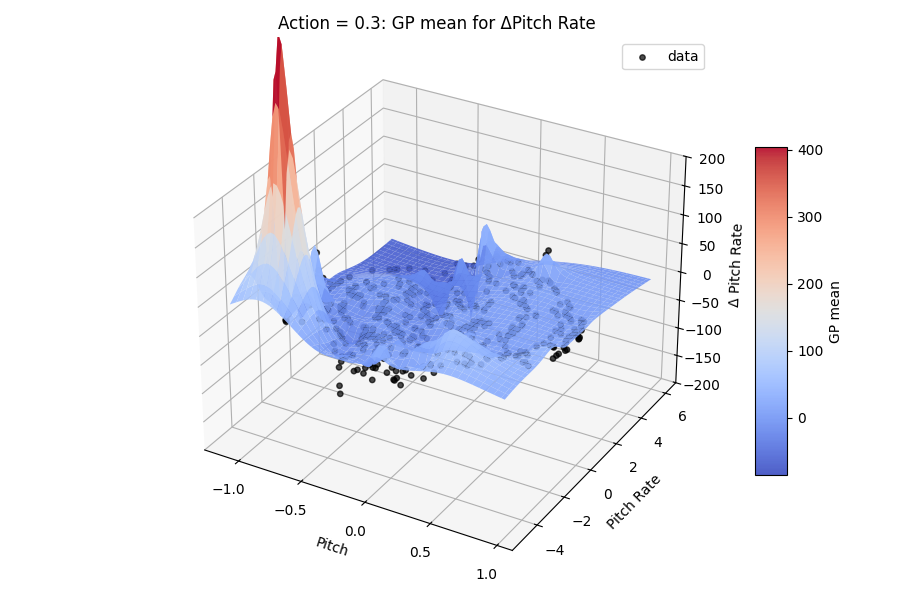

Plotting for action a=1.0
Values near action a=1.0 n=263


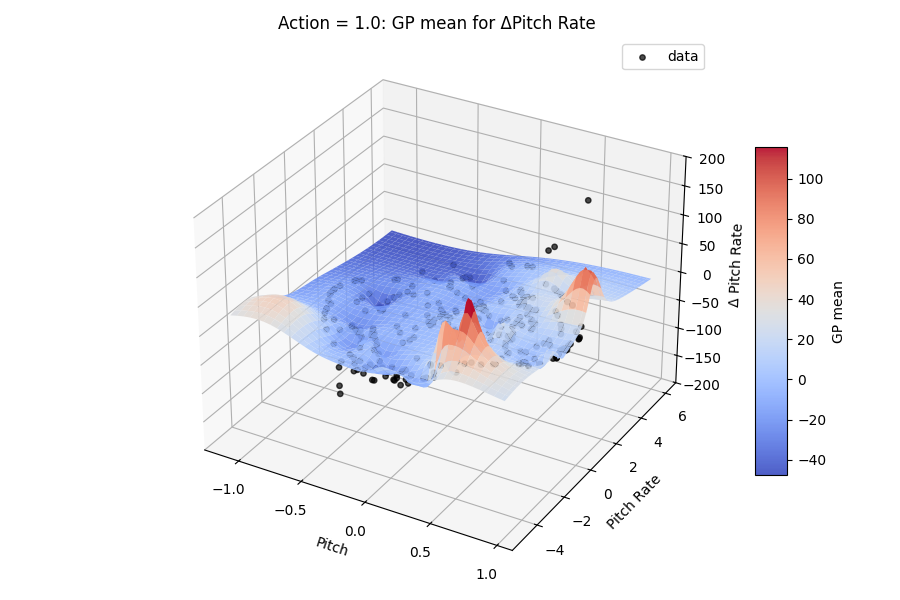

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # e.g. GP for Δpitch_rate (or whatever output[1] is)
a_values = [-1.0, 0.27, 1.0]  # representative actions

# Get raw training data (NumPy, via dataset())
X_train, Y_train = gp.dataset()
pitch, dpitch, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
ddpitch = Y_train  # targets for this GP (e.g. Δpitch_rate)

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pitch.min(), pitch.max()
v_min, v_max = dpitch.min(), dpitch.max()

p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------

def plot_surface(P, V, Mean, pitch, dpitch, ddpitch, act, a_fixed):

    for a_fixed in a_values:
        print(f"Plotting for action a={a_fixed}")

        # Build grid inputs: [pitch, pitch_rate, action]
        X_grid = np.column_stack([
            P.ravel(),                 # pitch
            V.ravel(),                 # pitch_rate
            np.full_like(P.ravel(), a_fixed)  # fixed action
        ])

        # --- Use NumPy-friendly predict for visualization ---
        Mean, var = gp.predict_torch(X_grid)          # Mean: (N_points,)
        Mean = Mean.detach().cpu().numpy().reshape(P.shape)            # reshape to grid

        # --------------------------------------------------------
        # Plot as surface
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                            linewidth=0, antialiased=True, alpha=0.9)

        # Overlay training data close to this action value
        mask = np.abs(act - a_fixed) < 0.5
        print(f"Values near action a={a_fixed} n={np.sum(mask)}")
        ax.scatter(
            pitch[mask], dpitch[mask], ddpitch[mask],
            color='k', s=15, alpha=0.7, label='data'
        )

        # --------------------------------------------------------
        # Labels and title
        ax.set_xlabel('Pitch')
        ax.set_ylabel('Pitch Rate')
        ax.set_zlabel('Δ Pitch Rate')
        ax.set_zlim(-200, 200)
        ax.set_title(f"Action = {a_fixed:.1f}: GP mean for ΔPitch Rate")

        fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
        ax.legend()
        plt.tight_layout()
        plt.show()


plot_surface(P, V, None, pitch, dpitch, ddpitch, act, a_values)


Values near action a=1.0 → n=263


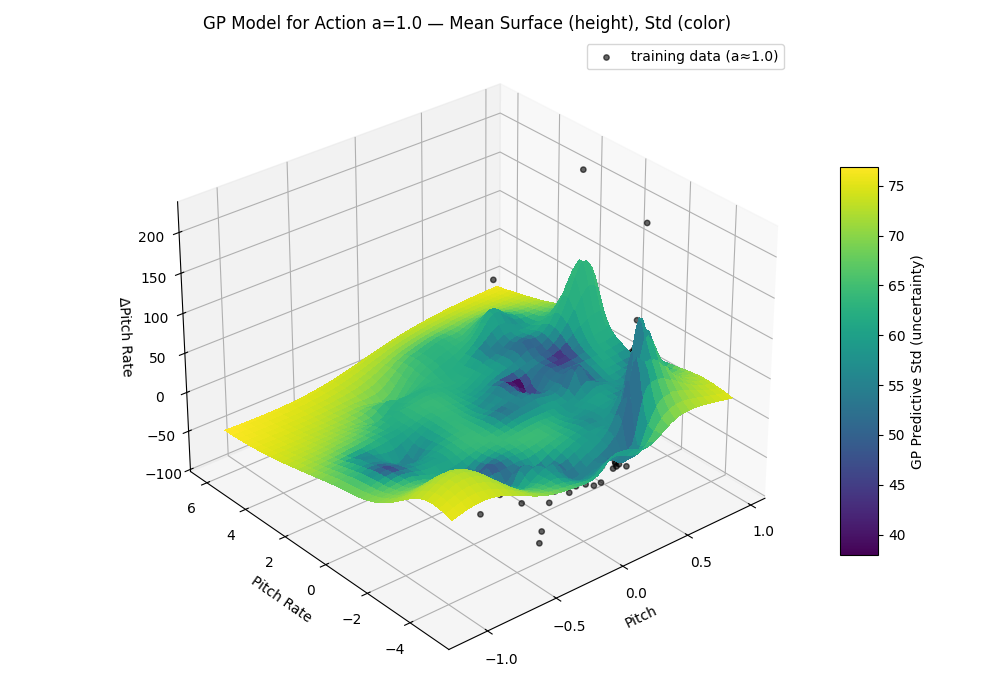

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # e.g. GP for Δpitch_rate (index 0 would be Δpitch)
a_fixed = 1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data (NumPy from dataset())
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pitch, pitch_rate, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
d_pitch_rate = Y_train  # targets for this GP

# Select samples close to a = a_fixed for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define pitch–pitch_rate grid
# --------------------------------------------------------
p_min, p_max = pitch.min(), pitch.max()
v_min, v_max = pitch_rate.min(), pitch_rate.max()

p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action: [pitch, pitch_rate, a_fixed]
X_grid = np.column_stack([
    P.ravel(),                     # pitch
    V.ravel(),                     # pitch_rate
    np.full_like(P.ravel(), a_fixed)  # fixed action
])

# --------------------------------------------------------
# GP predictions (torch -> numpy)
# --------------------------------------------------------
Mean_t, Var_t = gp.predict_torch(X_grid)   # torch tensors on GPU

# move to CPU and numpy for plotting
Mean = Mean_t.detach().cpu().numpy().reshape(P.shape)
Var  = Var_t.detach().cpu().numpy().reshape(P.shape)
Std  = np.sqrt(Var)

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors,
    linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pitch[mask], pitch_rate[mask], d_pitch_rate[mask],
    color='k', s=15, alpha=0.6, label=f'training data (a≈{a_fixed})'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Pitch')
ax.set_ylabel('Pitch Rate')
ax.set_zlabel('ΔPitch Rate')
ax.set_title(f"GP Model for Action a={a_fixed:.1f} — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


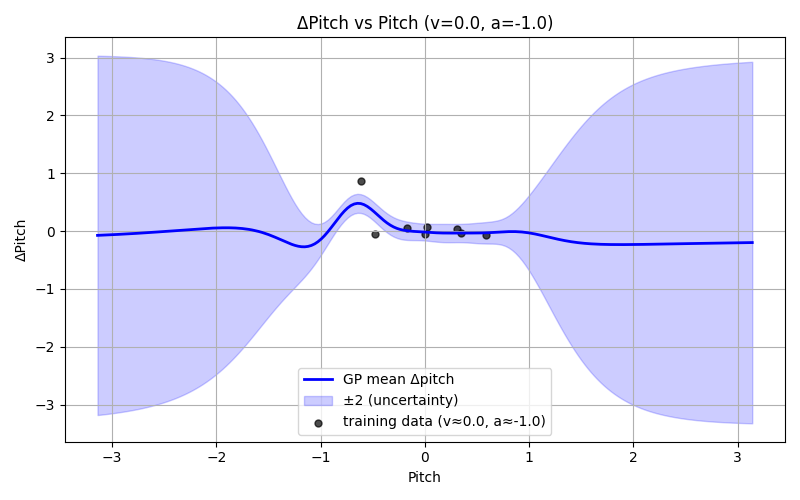

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δpitch model
# --------------------------------------------------------
gp = gps[0]       # GP for Δpitch (index 1 would be Δpitch_rate)
v_fixed = 0.0     # fix pitch_rate
a_fixed = -1.0    # fix action

# --------------------------------------------------------
# Define pitch grid
# --------------------------------------------------------
p_min, p_max = -3.14, 3.14
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [pitch, v_fixed, a_fixed]
X_query = np.column_stack([
    p_grid,
    np.full_like(p_grid, v_fixed),
    np.full_like(p_grid, a_fixed)
])

# --------------------------------------------------------
# Predict GP mean and std (torch -> numpy)
# --------------------------------------------------------
Mean_t, Var_t = gp.predict_torch(X_query)   # torch tensors on GPU
Mean = Mean_t.detach().cpu().numpy()
Var  = Var_t.detach().cpu().numpy()
Std  = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δpitch')
plt.fill_between(
    p_grid,
    Mean - 2 * Std,
    Mean + 2 * Std,
    color='blue',
    alpha=0.2,
    label='±2 (uncertainty)'
)

# --------------------------------------------------------
# Overlay training data near v=v_fixed and a=a_fixed
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.1) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)

plt.scatter(
    X_train[mask, 0],   # pitch
    Y_train[mask],      # Δpitch
    color='k', s=25, alpha=0.7,
    label=f'training data (v≈{v_fixed}, a≈{a_fixed})'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Pitch")
plt.ylabel("ΔPitch")
plt.title(f"ΔPitch vs Pitch (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# MPPI CONTROLLER

#### GP step for the MuJoCo car (using your learned GP)

In [13]:
import numpy as np

# --------------------------------------------------------------
# MPPI parameters (tune these)
# --------------------------------------------------------------
# H       = 80            # prediction horizon (in model steps, e.g. ~6 s if CTRL_DT=0.1)
# K       = 2000           # number of sampled trajectories
# LAMBDA  = 1.0           # temperature
# SIGMA   = 0.6           # std dev of exploration noise
# rng     = np.random.default_rng(0)

# # Action bounds from your MuJoCo controller
act_low  = U_MIN    # e.g. -1.0
act_high = U_MAX    # e.g. +1.0

# --------------------------------------------------------------
# GP-based one-step model for the car
#   state = [pitch, pitch_rate]
#   action = throttle
#   gps[0] => Δpitch, gps[1] => Δpitch_rate
# --------------------------------------------------------------
def gp_step_batch_torch(states, actions):
    """
    states : (K, 2) torch.FloatTensor on device
    actions: (K,)   torch.FloatTensor on device
    returns next_states: (K, 2) torch.FloatTensor on device
    """
    # stack to [pitch, pitch_rate, action]
    X = torch.stack([states[:, 0], states[:, 1], actions], dim=-1)

    d_pitch_mean, _ = gps[0].predict_torch(X)
    d_rate_mean,  _ = gps[1].predict_torch(X)

    next_states = torch.empty_like(states)
    # next_states[:, 0] = states[:, 0] + d_pitch_mean
    # next_states[:, 1] = states[:, 1] + d_rate_mean
    next_states[:, 0] = states[:, 0] + d_pitch_mean * dt
    next_states[:, 1] = states[:, 1] + d_rate_mean * dt

    next_states[:, 0].clamp_(-np.pi, np.pi)
    next_states[:, 1].clamp_(-20.0, 20.0)

    return next_states



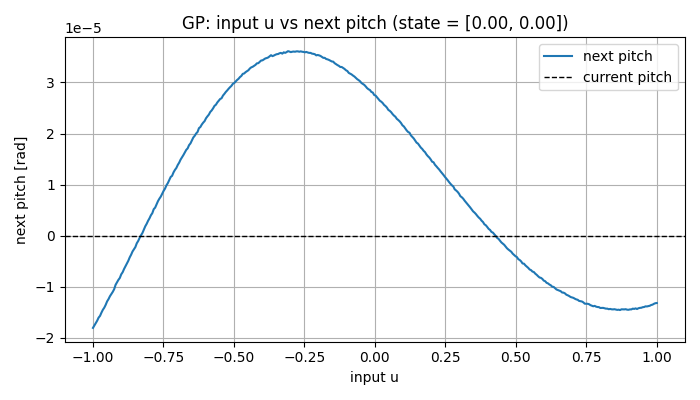

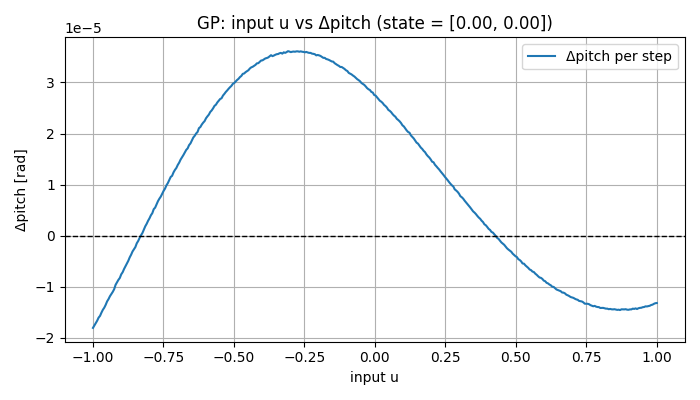

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ----- choose a fixed state (pitch, pitch_rate) -----
pitch0 = 0.0   # for example: start near upright
rate0  = 0.0   # no angular velocity

# sweep inputs
N_u    = 400
u_vals = np.linspace(-1, 1, N_u).astype(np.float32)

# build batch for GP (on GPU)
states  = torch.tensor([[pitch0, rate0]], dtype=torch.float32, device=device).repeat(N_u, 1)  # (N_u, 2)
actions = torch.tensor(u_vals, dtype=torch.float32, device=device)                            # (N_u,)

with torch.no_grad():
    next_states = gp_step_batch_torch(states, actions)   # (N_u, 2) -> [next_pitch, next_rate]

next_pitch = next_states[:, 0].detach().cpu().numpy()
delta_pitch = next_pitch - pitch0

# ----- plot input vs output -----
plt.figure(figsize=(7, 4))
plt.plot(u_vals, next_pitch, label="next pitch")
plt.axhline(pitch0, color='k', linestyle='--', linewidth=1, label="current pitch")
plt.xlabel("input u")
plt.ylabel("next pitch [rad]")
plt.title(f"GP: input u vs next pitch (state = [{pitch0:.2f}, {rate0:.2f}])")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(u_vals, delta_pitch, label="Δpitch per step")
plt.axhline(0.0, color='k', linestyle='--', linewidth=1)
plt.xlabel("input u")
plt.ylabel("Δpitch [rad]")
plt.title(f"GP: input u vs Δpitch (state = [{pitch0:.2f}, {rate0:.2f}])")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### COST FUNCTION

In [15]:
# import torch

# device = torch.device("cuda")
# pitch_target_t = torch.tensor(2.5, dtype=torch.float32, device=device)

# def stage_cost_torch(states, actions):
#     """
#     states : (K, 2) torch.float32 on device  -> [pitch, pitch_rate]
#     actions: (K,)   torch.float32 on device  -> throttle
#     returns: (K,)   torch.float32 cost
#     """
#     pitch = states[:, 0]
#     rate  = states[:, 1]
#     u     = actions

#     err = pitch - pitch_target_t

#     cost_pitch = 100.0 * err**2
#     cost_rate  = 0.5  * rate**2
#     cost_u     = 0.1  * u**2

#     return cost_pitch + cost_rate + cost_u



# import torch

# device = torch.device("cuda")

# # Target magnitude of pitch (rad), sign doesn't matter
# pitch_target_abs = torch.tensor(np.pi, dtype=torch.float32, device=device)

# def stage_cost_torch(states, actions):
#     """
#     states : (K, 2) torch.float32 on device  -> [pitch, pitch_rate]
#     actions: (K,)   torch.float32 on device  -> throttle
#     returns: (K,)   torch.float32 cost
#     """
#     pitch = states[:, 0]
#     rate  = states[:, 1]
#     u     = actions

#     # distance of |pitch| to target magnitude 2.5
#     err_mag = torch.abs(pitch).to(device) - pitch_target_abs

#     cost_pitch = 1000.0 * err_mag**2      # min at pitch = ±2.5
#     cost_rate  = 0.5  * rate**2
#     cost_u     = 0.1  * u**2

#     return cost_pitch + cost_rate + cost_u




# pitch_target = torch.tensor(np.pi, device=device)
# def angdiff(a, b):
#     return ((a - b + math.pi) % (2*math.pi)) - math.pi

# def stage_cost_torch(states, actions):
#     pitch = states[:, 0]
#     rate  = states[:, 1]
#     u     = actions
#     err = angdiff(pitch, pitch_target)
#     cost_pitch = 100.0 * err**2
#     cost_rate  = 1.0  * rate**2
#     cost_u     = 0.05 * u**2
#     return cost_pitch + cost_rate + cost_u



import torch, math

pitch_target = torch.tensor(np.pi, device=device)   # or π, see next section

def angdiff(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """Shortest signed angular difference a-b in (-pi, pi]."""
    return torch.remainder(a - b + torch.pi, 2 * torch.pi) - torch.pi

def stage_cost_torch(states: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
    """
    states : (K, 2)  -> [angle_state, angular_rate]
    actions: (K,)    -> throttle
    returns: (K,) cost
    """
    pitch = states[:, 0]
    rate  = states[:, 1]
    u     = actions

    err = angdiff(pitch, pitch_target)

    cost_pitch = 100.0 * err**2
    # if pitch is the “flip” angle w.r.t upright:
    orient_cost = 100 * (1.0 + torch.cos(pitch))**2  # 0 when upside down, large when upright
    cost_rate  = 0.1  * rate**2
    cost_u     = 0.01 * u**2

    #return cost_pitch + cost_rate + cost_u
    return orient_cost + cost_rate + cost_u + cost_pitch
    #return orient_cost


#### MPPI ACTION

In [16]:
@torch.no_grad()
def mppi_action_torch(x0, u_init=None):
    """
    x0     : current state [pitch, pitch_rate] (np or torch)
    u_init : previous MPPI plan (length H) for warm-start, or None

    returns:
      u0   : scalar action to apply now (float)
      u_new: updated plan (torch tensor length H on device)
    """
    # convert x0 to torch on device
    x0 = torch.as_tensor(x0, dtype=torch.float32, device=device)
    assert x0.shape == (2,), f"Expected x0 shape (2,), got {x0.shape}"

    # nominal control sequence on device
    if u_init is None:
        u_init = torch.zeros(H, dtype=torch.float32, device=device)
    else:
        u_init = torch.as_tensor(u_init, dtype=torch.float32, device=device)
        assert u_init.shape[0] == H

    # sample noise on GPU
    eps = torch.randn(K, H, device=device) * SIGMA
    U   = torch.clamp(u_init.unsqueeze(0) + eps, act_low, act_high)  # (K,H)

    # rollout trajectories under GP model
    states = x0.unsqueeze(0).repeat(K, 1)        # (K,2)
    costs  = torch.zeros(K, dtype=torch.float32, device=device)

    for t in range(H):
        u_t = U[:, t]                            # (K,)
        costs = costs + stage_cost_torch(states, u_t)
        states = gp_step_batch_torch(states, u_t)

    # print("[COST VALUE]: ", costs.min())

    # MPPI weighting
    J_min   = costs.min()
    weights = torch.exp(-(costs - J_min) / LAMBDA)
    weights_sum = weights.sum() + 1e-8

    # Weighted update of the control sequence
    du    = (weights.unsqueeze(1) * eps).sum(dim=0) / weights_sum   # (H,)
    u_new = torch.clamp(u_init + du, act_low, act_high)             # (H,)

    # First action as Python float for MuJoCo ctrl[:]
    u0 = float(u_new[0].detach().cpu().item())

    return u0, u_new.detach()


### Run Mujoco Simulation

In [17]:
# import time, math, numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output
# import mujoco as mj
# import mujoco.viewer as viewer

# # -------- config (same spirit as your training loop) --------
# CTRL_DT   = 0.1          # control update period (sim seconds)
# DURATION  = 20.0         # total run time (sim seconds)
# U_MIN, U_MAX = -1.0, 1.0
# RTF      = 1.0           # 1.0 = real-time, >1.0 = faster than real time
# REFRESH_HZ = 6           # plot refresh rate
# MODEL_XML = "monstertruck.xml"

# # -------- model + sensors --------
# m = mj.MjModel.from_xml_path(MODEL_XML)
# data = mj.MjData(m)
# mj.mj_resetData(m, data); mj.mj_forward(m, data)
# data.ctrl[:] = 0.0

# sim_dt = float(m.opt.timestep)
# free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
# qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
# if gyro_id < 0:
#     raise RuntimeError("imu_gyro sensor not found in model XML")
# gyro_adr = m.sensor_adr[gyro_id]

# acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
# if acc_id < 0:
#     raise RuntimeError("imu_acc sensor not found in model XML")
# acc_adr = m.sensor_adr[acc_id]

# # -------- plotting --------
# plt.ioff()
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

# (line_pitch,)   = ax1.plot([], [], lw=1.4)
# (line_flip,)    = ax2.plot([], [], lw=1.4)
# (line_u,)       = ax3.plot([], [], lw=1.4)
# (line_rate,)    = ax4.plot([], [], lw=1.4)
# (line_acc,)     = ax5.plot([], [], lw=1.0)

# ax1.set_ylabel("Euler pitch [rad]")
# ax1.set_ylim(-np.pi, np.pi); ax1.grid(True, linewidth=0.3)

# ax2.set_ylabel("flip_rel [rad]")
# ax2.set_ylim(-4.0, 4.0); ax2.grid(True, linewidth=0.3)

# ax3.set_ylabel("u")
# ax3.set_ylim(U_MIN-0.1, U_MAX+0.1); ax3.grid(True, linewidth=0.3)

# ax4.set_ylabel("pitch rate [rad/s]")
# ax4.set_ylim(-10, 10); ax4.grid(True, linewidth=0.3)

# ax5.set_ylabel("acc imu")
# ax5.set_ylim(-50, 50); ax5.set_xlabel("time [s]"); ax5.grid(True, linewidth=0.3)

# fig.tight_layout()
# display(fig)

# # -------- logs --------
# t_log         = []
# pitch_log     = []
# flip_rel_log  = []
# u_log         = []
# rate_log      = []
# acc_log       = []

# last_refresh_wall = time.perf_counter()

# # unwrap state for flip_rel (same as your data-collection code)
# prev_theta = None
# prev_theta_unwrapped = 0.0
# theta0 = None   # reference angle so flip_rel starts near 0

# # MPPI warm-start plan
# plan = None

# with viewer.launch_passive(m, data) as v:
#     t0_sim   = data.time
#     t0_wall  = time.perf_counter()
#     next_cmd = t0_sim
#     u = 0.0

#     while data.time - t0_sim < DURATION:
#         # -------- 1) Read state (orientation + IMU) --------
#         qw, qx, qy, qz = data.qpos[qadr:qadr+4]
#         R, euler_pitch = quat_to_R_and_pitch(qw, qx, qy, qz)

#         # body "up" vector (third column of R)
#         up_x, up_y, up_z = R[0, 2], R[1, 2], R[2, 2]

#         # angle in (z,x) plane (same as training code)
#         theta = math.atan2(up_x, up_z)  # in [-pi, pi]
#         prev_theta, theta_unwrapped = unwrap_angle(prev_theta,
#                                                    prev_theta_unwrapped,
#                                                    theta)
#         prev_theta_unwrapped = theta_unwrapped

#         if theta0 is None:
#             theta0 = theta_unwrapped
#         flip_rel = theta_unwrapped - theta0   # this is your angular state

#         # IMU
#         gyro = data.sensordata[gyro_adr:gyro_adr+3]
#         pitch_rate_imu = float(gyro[1])

#         acc = data.sensordata[acc_adr:acc_adr+3]
#         acc_imu = float(acc[0])

#         t_rel = data.time - t0_sim

#         # -------- 2) MPPI control update --------
#         if data.time >= next_cmd:
#             # state fed to GP/MPPI: [flip_rel, angular_rate]
#             x0 = np.array([flip_rel, pitch_rate_imu], dtype=np.float32)

#             u_cmd, plan = mppi_action_torch(x0, plan)
#             u = float(np.clip(u_cmd, U_MIN, U_MAX))
#             data.ctrl[:] = u

#             next_cmd += CTRL_DT

#         # -------- 3) Physics step --------
#         mj.mj_step(m, data)

#         # -------- 4) Log for plotting & GP debugging --------
#         t_log.append(t_rel)
#         pitch_log.append(euler_pitch)
#         flip_rel_log.append(flip_rel)
#         u_log.append(u)
#         rate_log.append(pitch_rate_imu)
#         acc_log.append(acc_imu)

#         # -------- 5) Live plotting --------
#         now = time.perf_counter()
#         if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
#             line_pitch.set_data(t_log, pitch_log)
#             line_flip.set_data(t_log, flip_rel_log)
#             line_u.set_data(t_log, u_log)
#             line_rate.set_data(t_log, rate_log)
#             line_acc.set_data(t_log, acc_log)

#             ax1.set_xlim(0.0, max(2.0, t_rel))
#             clear_output(wait=True)
#             display(fig)
#             last_refresh_wall = now

#         # -------- 6) Real-time pacing --------
#         sim_elapsed  = data.time - t0_sim
#         target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
#         sleep_needed = target_wall - time.perf_counter()
#         if sleep_needed > 0:
#             time.sleep(min(sleep_needed, 0.01))

#         v.sync()

# # -------- final plot (static) --------
# line_pitch.set_data(t_log, pitch_log)
# line_flip.set_data(t_log, flip_rel_log)
# line_u.set_data(t_log, u_log)
# line_rate.set_data(t_log, rate_log)
# line_acc.set_data(t_log, acc_log)
# ax1.set_xlim(0.0, max(2.0, t_log[-1] if t_log else 2.0))
# clear_output(wait=True)
# display(fig)

# print(f"Done. Samples: {len(t_log)}   Sim time: {t_log[-1]:.3f}s")


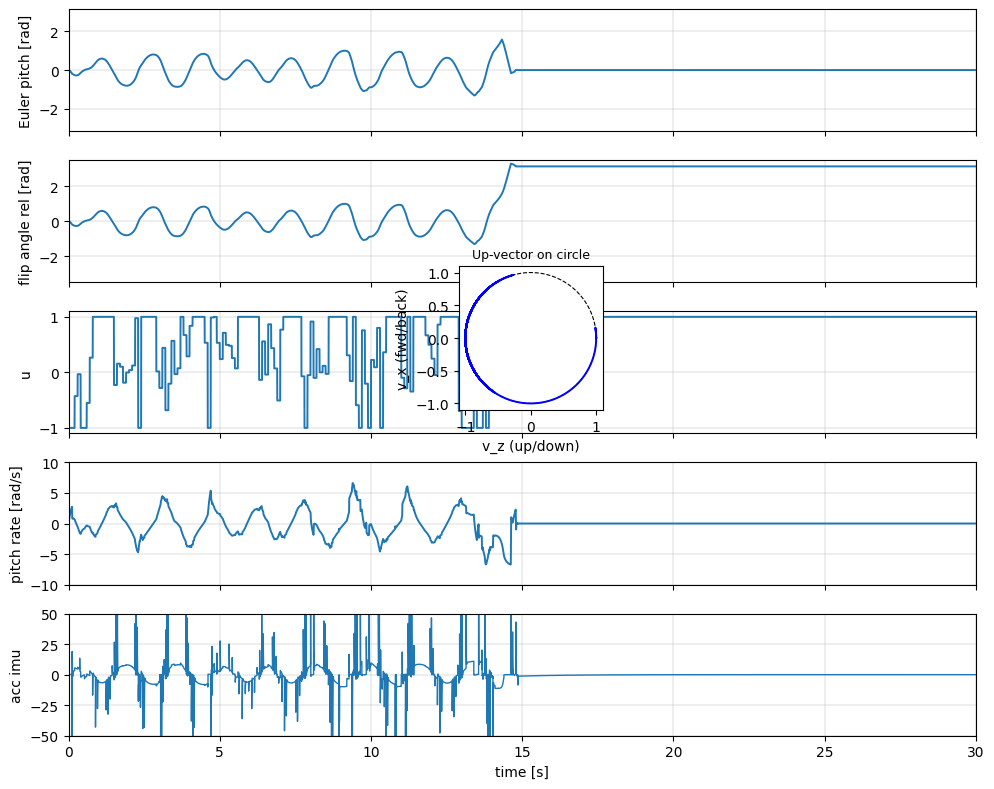

Done. Samples: 30000  Sim time: 30.000s


In [23]:
import time, math, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mujoco as mj
import mujoco.viewer as viewer

# ------------------ config ------------------
CTRL_DT   = 0.1
DURATION  = 30.0
U_MIN, U_MAX = -1.0, 1.0
RTF      = 1.0
REFRESH_HZ = 5
MODEL_XML = "monstertruck.xml"


#------------------ MPPI parameters ------------------
H       = 20            # prediction horizon (in model steps, e.g. ~6 s if CTRL_DT=0.1)
K       = 2000           # number of sampled trajectories
LAMBDA  = 1.0           # temperature
SIGMA   = 1.6           # std dev of exploration noise



# ------------------ model + sensors ------------------
m = mj.MjModel.from_xml_path(MODEL_XML)
data = mj.MjData(m)
mj.mj_resetData(m, data); mj.mj_forward(m, data)
data.ctrl[:] = 0.0

sim_dt        = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
if gyro_id < 0:
    raise RuntimeError("imu_gyro sensor not found in model XML")
gyro_adr = m.sensor_adr[gyro_id]

acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
if acc_id < 0:
    raise RuntimeError("imu_acc sensor not found in model XML")
acc_adr = m.sensor_adr[acc_id]

# ------------------ plotting ------------------
plt.ioff()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

(line_pitch,)   = ax1.plot([], [], lw=1.4)
(line_flip,)    = ax2.plot([], [], lw=1.4)
(line_u,)       = ax3.plot([], [], lw=1.4)
(line_rate,)    = ax4.plot([], [], lw=1.4)
(line_acc,)     = ax5.plot([], [], lw=1.0)

ax1.set_ylabel("Euler pitch [rad]")
ax1.set_ylim(-np.pi, np.pi); ax1.grid(True, linewidth=0.3)

ax2.set_ylabel("flip angle rel [rad]")
ax2.set_ylim(-3.5, 3.5); ax2.grid(True, linewidth=0.3)

ax3.set_ylabel("u")
ax3.set_ylim(U_MIN-0.1, U_MAX+0.1); ax3.grid(True, linewidth=0.3)

ax4.set_ylabel("pitch rate [rad/s]")
ax4.set_ylim(-10, 10); ax4.grid(True, linewidth=0.3)

ax5.set_ylabel("acc imu")
ax5.set_ylim(-50, 50); ax5.set_xlabel("time [s]"); ax5.grid(True, linewidth=0.3)

# small inset axis for the up-vector (v_z, v_x)
ax_up = fig.add_axes([0.45, 0.48, 0.18, 0.18])  # [left, bottom, width, height]
theta_circle = np.linspace(-np.pi, np.pi, 200)
ax_up.plot(np.cos(theta_circle), np.sin(theta_circle), 'k--', linewidth=0.8)
(line_upvec,) = ax_up.plot([], [], 'b-', lw=1.4)
ax_up.set_aspect('equal', adjustable='box')
ax_up.set_xlim(-1.1, 1.1)
ax_up.set_ylim(-1.1, 1.1)
ax_up.set_xlabel("v_z (up/down)")
ax_up.set_ylabel("v_x (fwd/back)")
ax_up.set_title("Up-vector on circle", fontsize=9)

fig.tight_layout()
display(fig)

# ------------------ logs ------------------
_t_log         = []
_pitch_log     = []
_flip_rel_log  = []
_u_log         = []
_rate_log      = []
_acc_log       = []
_vz_log        = []
_vx_log        = []

last_refresh_wall = time.perf_counter()

t0_sim   = data.time
t0_wall  = time.perf_counter()
next_cmd = t0_sim
u = 0.0

# for angle unwrapping & reference
prev_theta = None
prev_theta_unwrapped = 0.0
theta0 = None  # reference angle at t=0 (so flip_rel starts near 0)

# MPPI warm-start plan (MUST start as None!)
plan = None

with viewer.launch_passive(m, data) as v:
    while data.time - t0_sim < DURATION:
        # --- one physics step first ---
        mj.mj_step(m, data)

        # --- state & orientation ---
        qw, qx, qy, qz = data.qpos[qadr:qadr+4]
        R, euler_pitch = quat_to_R_and_pitch(qw, qx, qy, qz)

        # body "up" vector in world coordinates = 3rd column of R
        up_x, up_y, up_z = R[0, 2], R[1, 2], R[2, 2]

        # angle of up vector in (z,x) plane: atan2(v_x, v_z) in [-pi, pi]
        theta = math.atan2(up_x, up_z)

        # unwrap over time to avoid jump at ±pi
        prev_theta, theta_unwrapped = unwrap_angle(prev_theta, prev_theta_unwrapped, theta)
        prev_theta_unwrapped = theta_unwrapped

        # define reference at the first step so car starts near 0
        if theta0 is None:
            theta0 = theta_unwrapped
        flip_rel = theta_unwrapped - theta0  # your "progress" angle

        # IMU signals
        gyro = data.sensordata[gyro_adr:gyro_adr+3]
        pitch_rate_imu = float(gyro[1])

        acc = data.sensordata[acc_adr:acc_adr+3]
        acc_imu = float(acc[0])

        t_rel = data.time - t0_sim

        # --- MPPI control update (once every CTRL_DT) ---
        if data.time >= next_cmd:
            # state for MPPI: [flip_rel, pitch_rate_imu]
            x0 = np.array([flip_rel, pitch_rate_imu], dtype=np.float32)

            if flip_rel >= 3.140 or flip_rel <= -3.140:
                data.ctrl[:] = 0.0
            else:
                # SINGLE MPPI CALL
                u_cmd, plan = mppi_action_torch(x0, plan)
                u = float(np.clip(u_cmd, U_MIN, U_MAX))
                #u = float(np.clip(flip_policy(t_rel, U_MIN, U_MAX), U_MIN, U_MAX))
                data.ctrl[:] = u
                next_cmd += CTRL_DT

            # # SINGLE MPPI CALL
            # u_cmd, plan = mppi_action_torch(x0, plan)
            # u = float(np.clip(u_cmd, U_MIN, U_MAX))
            # #u = float(np.clip(flip_policy(t_rel, U_MIN, U_MAX), U_MIN, U_MAX))
            # data.ctrl[:] = u
            # next_cmd += CTRL_DT

        # --- log ---
        _t_log.append(t_rel)
        _pitch_log.append(euler_pitch)
        _flip_rel_log.append(flip_rel)
        _u_log.append(u)
        _rate_log.append(pitch_rate_imu)
        _acc_log.append(acc_imu)
        _vz_log.append(up_z)
        _vx_log.append(up_x)

        # --- plotting ---
        now = time.perf_counter()
        if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
            line_pitch.set_data(_t_log, _pitch_log)
            line_flip.set_data(_t_log, _flip_rel_log)
            line_u.set_data(_t_log, _u_log)
            line_rate.set_data(_t_log, _rate_log)
            line_acc.set_data(_t_log, _acc_log)

            line_upvec.set_data(_vz_log, _vx_log)

            ax1.set_xlim(0.0, max(2.0, t_rel))
            clear_output(wait=True)
            display(fig)
            last_refresh_wall = now

        # --- real-time pacing ---
        sim_elapsed  = data.time - t0_sim
        target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
        sleep_needed = target_wall - time.perf_counter()
        if sleep_needed > 0:
            time.sleep(min(sleep_needed, 0.01))

        # if flip_rel >= 3.140 or flip_rel <= -3.140:
        #     break

        v.sync()

# final draw
line_pitch.set_data(_t_log, _pitch_log)
line_flip.set_data(_t_log, _flip_rel_log)
line_u.set_data(_t_log, _u_log)
line_rate.set_data(_t_log, _rate_log)
line_acc.set_data(_t_log, _acc_log)
line_upvec.set_data(_vz_log, _vx_log)

ax1.set_xlim(0.0, max(2.0, _t_log[-1] if _t_log else 2.0))
clear_output(wait=True) 
display(fig)

print(f"Done. Samples: {len(_t_log)}  Sim time: {_t_log[-1]:.3f}s")

In [ ]:
# def plot_state_action(angles, ang_speeds, throttles):
#     skip = 10
#     angles = np.array(angles[::skip])
#     ang_speeds = np.array(ang_speeds[::skip])
#     throttles = np.array(throttles[::skip])

#     plt.figure(figsize=(8, 6))
#     sc = plt.scatter(angles, ang_speeds, c=throttles,
#                      cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

#     plt.colorbar(sc, label="Throttle action")
#     plt.xlabel("Angle")
#     plt.ylabel("Angular speed")
#     plt.title("Trajectory — Colored by Throttle Action")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# plot_state_action(_flip_rel_log, _rate_log, _u_log)

# Re Train and Re Run

In [ ]:
# import numpy as np

# # ============================================================
# # 1) Build dataset from the latest episode logs
# #    Inputs X_t  = [pitch_t, pitch_rate_t, u_t]
# #    Targets Y_t = [rate_t, acc_t]   (you chose this structure)
# #    Then subsample every `step` samples before adding to GP.
# # ============================================================

#         # _t_log.append(t_rel)
#         # _pitch_log.append(euler_pitch)
#         # _flip_rel_log.append(flip_rel)
#         # _u_log.append(u)
#         # _rate_log.append(pitch_rate_imu)
#         # _acc_log.append(acc_imu)
#         # _vz_log.append(up_z)
#         # _vx_log.append(up_x)

# # Convert logs to numpy
# pitch_arr   = np.asarray(_flip_rel_log,      dtype=np.float32)
# rate_arr    = np.asarray(_rate_log,   dtype=np.float32)   # pitch rate from IMU
# acc_arr     = np.asarray(_acc_log,   dtype=np.float32)   # filtered acceleration
# u_arr       = np.asarray(_u_log,          dtype=np.float32)

# # Make sure all arrays have same length
# N = min(len(pitch_arr), len(rate_arr), len(acc_arr), len(u_arr))
# pitch_arr = pitch_arr[:N]
# rate_arr  = rate_arr[:N]
# acc_arr   = acc_arr[:N]
# u_arr     = u_arr[:N]

# # Inputs at time t: [pitch_t, rate_t, u_t]
# X_full = np.stack([pitch_arr[:-1], rate_arr[:-1], u_arr[:-1]], axis=1)

# # Targets: you are currently using [rate_t, acc_t] as outputs
# # (first component is rate at time t, second is acceleration at time t)
# Y_full = np.stack([
#     rate_arr[:-1],   # "rate" output
#     acc_arr[:-1]     # "acceleration" output
# ], axis=1)

# print("Full X_full shape:", X_full.shape)
# print("Full Y_full shape:", Y_full.shape)

# # ============================================================
# # 2) Subsample: take every `step` sample to control GP size
# # ============================================================
# step = 100   # you can tune this (e.g. 50, 200, ...)
# X_new = X_full[::step]
# Y_new = Y_full[::step]

# print("Subsampled X_new shape:", X_new.shape)
# print("Subsampled Y_new shape:", Y_new.shape)

# # ============================================================
# # 3) Incremental GP update with add_data()
# #    - Assumes `gps` already exists and has length 2:
# #      gps[0] => model for first output (rate)
# #      gps[1] => model for second output (acc)
# # ============================================================

# # Safety check: if gps doesn't exist yet, fall back to full fit
# if "gps" not in globals():
#     print("`gps` not found. Creating and fitting new GPs from this episode only.")
#     n_output = Y_new.shape[1]
#     gps = [GPManager(kernel='RQ', iters=300, device=device) for _ in range(n_output)]
#     for d in range(n_output):
#         gps[d].fit(X_new, Y_new[:, d])
#         print(f"Initialized GP[{d}] with {X_new.shape[0]} samples.")
# else:
#     # Incremental: add new data to each GP and retrain
#     n_output = Y_new.shape[1]
#     assert len(gps) == n_output, f"Expected {n_output} GPs, found {len(gps)}"

#     for d in range(n_output):
#         gps[d].add_data(X_new, Y_new[:, d], retrain=True)
#         print(f"Updated GP[{d}] with +{X_new.shape[0]} samples (total now {gps[d].X_train.shape[0]}).")

# print("GP update done.")


# PLOT SURFACES AGAIN

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# # --------------------------------------------------------
# # Visualization setup
# # --------------------------------------------------------
# gp = gps[1]   # e.g. GP for Δpitch_rate (or whatever output[1] is)
# a_values = [-1.0, 0.0, 1.0]  # representative actions

# # Get raw training data (NumPy, via dataset())
# X_train, Y_train = gp.dataset()
# pitch, dpitch, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
# ddpitch = Y_train  # targets for this GP (e.g. Δpitch_rate)

# # --------------------------------------------------------
# # Define grid for visualization
# # --------------------------------------------------------
# p_min, p_max = pitch.min(), pitch.max()
# v_min, v_max = dpitch.min(), dpitch.max()

# p_grid = np.linspace(p_min, p_max, 80)
# v_grid = np.linspace(v_min, v_max, 80)
# P, V = np.meshgrid(p_grid, v_grid)

# # --------------------------------------------------------
# # Generate and plot for each action
# # --------------------------------------------------------

# plot_surface(P, V, None, pitch, dpitch, ddpitch, act, a_values)


# RE RUN THE MPPI AGAIN

In [ ]:
# # ====== 4) MuJoCo + MPPI control loop with live plotting + flip detection ======

# import time, math, numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output
# import mujoco as mj
# import mujoco.viewer as viewer

# # -------- config --------
# CTRL_DT   = 0.1          # control update period (sim seconds)
# DURATION  = 60.0         # max run time (sim seconds)
# U_MIN, U_MAX = -1.0, 1.0 # throttle bounds
# RTF      = 1.0           # realtime factor
# REFRESH_HZ = 10          # plot refresh rate (wall-clock Hz)

# MODEL_XML = "monstertruck.xml"

# # --------------------------------------------------------------
# # MPPI parameters (you already tuned these)
# # --------------------------------------------------------------
# H       = 20             # prediction horizon (in model steps)
# K       = 4000           # number of sampled trajectories
# LAMBDA  = 1.0            # temperature
# SIGMA   = 0.9            # std dev of exploration noise
# rng     = np.random.default_rng(0)

# act_low  = U_MIN
# act_high = U_MAX

# # --------------------------------------------------------------
# # Helper: z-component of body "up" axis in world frame
# # --------------------------------------------------------------
# def body_up_z(qw, qx, qy, qz):
#     """
#     Returns the z component of the body z-axis in world coordinates.
#     For an upright car:   up_z ≈ +1
#     For a turtle car:     up_z ≈ -1
#     """
#     # This is R22 of the rotation matrix from quaternion (w,x,y,z)
#     return 1.0 - 2.0 * (qx*qx + qy*qy)

# # Thresholds for deciding that the flip is finished
# UP_Z_CROSS_THR = 0.0    # sign change from initial up_z
# RATE_DONE_THR  = 0.5    # rad/s; small angular velocity

# # -------- model --------
# m = mj.MjModel.from_xml_path(MODEL_XML)
# data = mj.MjData(m)
# mj.mj_resetData(m, data); mj.mj_forward(m, data)
# data.ctrl[:] = 0.0

# sim_dt        = float(m.opt.timestep)
# steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
# free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
# qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# # --- IMU gyro sensor (for pitch rate) ---
# gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
# if gyro_id < 0:
#     raise RuntimeError("imu_gyro sensor not found in model XML")
# gyro_adr = m.sensor_adr[gyro_id]

# # --- IMU acc sensor (for logging / future features) ---
# acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
# if acc_id < 0:
#     raise RuntimeError("imu_acc sensor not found in model XML")
# acc_adr = m.sensor_adr[acc_id]

# # -------- live plot setup --------
# plt.ioff()
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# (line_pitch,)    = ax1.plot([], [], lw=1.8)
# (line_u,)        = ax2.plot([], [], lw=1.4)
# (line_rate_imu,) = ax3.plot([], [], lw=1.4)
# (line_acc_imu,)  = ax4.plot([], [], lw=1.4)

# ax1.set_ylabel("pitch [rad]")
# ax1.set_ylim(-2, 2)
# ax1.grid(True, linewidth=0.3)

# ax2.set_ylabel("u")
# ax2.set_ylim(U_MIN - 0.1, U_MAX + 0.1)
# ax2.grid(True, linewidth=0.3)

# ax3.set_ylabel("pitch rate imu [rad/s]")
# ax3.set_ylim(-5.0, 5.0)
# ax3.grid(True, linewidth=0.3)

# ax4.set_ylabel("acc imu")
# ax4.set_ylim(-50.0, 50.0)
# ax4.set_xlabel("time [s]")
# ax4.grid(True, linewidth=0.3)

# fig.tight_layout()
# display(fig)

# # -------- logs --------
# t_log        = []
# pitch_log    = []
# u_log        = []
# rate_imu_log = []
# acc_imu_log  = []

# last_refresh_wall = time.perf_counter()

# # MPPI warm-start plan (length H, defined earlier)
# plan = None

# # Get initial orientation to know if we start turtle or upright
# qw0, qx0, qy0, qz0 = data.qpos[qadr:qadr+4]
# initial_up_z = body_up_z(qw0, qx0, qy0, qz0)
# flipped = False

# with viewer.launch_passive(m, data) as v:
#     t0_sim   = data.time
#     t0_wall  = time.perf_counter()
#     next_cmd = t0_sim
#     u        = 0.0

#     while (data.time - t0_sim) < DURATION and not flipped:
#         # ---- control update at CTRL_DT (sim time) ----
#         if data.time >= next_cmd and not flipped:
#             # read current pose
#             qw, qx, qy, qz = data.qpos[qadr:qadr+4]
#             _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)
#             up_z = body_up_z(qw, qx, qy, qz)

#             # pitch rate from IMU gyro (y-axis)
#             gyro = data.sensordata[gyro_adr : gyro_adr + 3]
#             pitch_rate_imu = float(gyro[1])

#             # ---- check if flip is done ----
#             # condition: body-up vector changed sign compared to initial,
#             # and angular rate is small (landed).
#             if np.sign(initial_up_z) != np.sign(up_z) and abs(pitch_rate_imu) < RATE_DONE_THR:
#                 flipped = True
#                 u = 0.0
#                 data.ctrl[:] = 0.0
#                 print(f"[MPPI] Flip detected at t={data.time - t0_sim:.2f}s, pitch={pitch:.2f}, up_z={up_z:.2f}")
#             else:
#                 # normal MPPI control step
#                 x0 = np.array([pitch, pitch_rate_imu], dtype=np.float32)
#                 u_cmd, plan = mppi_action_torch(x0, plan)
#                 u_cmd = float(np.clip(u_cmd, U_MIN, U_MAX))
#                 u = u_cmd
#                 data.ctrl[:] = u

#             next_cmd += CTRL_DT

#         # ---- one physics tick ----
#         mj.mj_step(m, data)

#         # read state for logging (always, even after flip)
#         qw, qx, qy, qz = data.qpos[qadr:qadr+4]
#         _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

#         gyro = data.sensordata[gyro_adr : gyro_adr + 3]
#         pitch_rate_imu = float(gyro[1])

#         acc = data.sensordata[acc_adr : acc_adr + 3]
#         acc_imu = float(acc[0])

#         t_rel = data.time - t0_sim

#         t_log.append(t_rel)
#         pitch_log.append(pitch)
#         u_log.append(u)
#         rate_imu_log.append(pitch_rate_imu)
#         acc_imu_log.append(acc_imu)

#         # ---- live plot at REFRESH_HZ ----
#         now = time.perf_counter()
#         if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
#             line_pitch.set_data(t_log, pitch_log)
#             line_u.set_data(t_log, u_log)
#             line_rate_imu.set_data(t_log, rate_imu_log)
#             line_acc_imu.set_data(t_log, acc_imu_log)

#             ax1.set_xlim(0.0, max(5.0, t_rel))
#             clear_output(wait=True)
#             display(fig)
#             last_refresh_wall = now

#         # ---- real-time pacing ----
#         sim_elapsed  = data.time - t0_sim
#         target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
#         sleep_needed = target_wall - time.perf_counter()
#         if sleep_needed > 0:
#             time.sleep(min(sleep_needed, 0.01))

#         v.sync()

# # final draw
# line_pitch.set_data(t_log, pitch_log)
# line_u.set_data(t_log, u_log)
# line_rate_imu.set_data(t_log, rate_imu_log)
# line_acc_imu.set_data(t_log, acc_imu_log)
# ax1.set_xlim(0.0, max(5.0, t_log[-1] if t_log else 5.0))
# clear_output(wait=True)
# display(fig)

# print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s   Flipped: {flipped}")
